In this notebook, we explore the application of Directed Acyclic Graph (DAG)-based Graph Neural Networks (GNNs) to learn a diffusion model over a DAG structure. The objective is to test whether different an architectures are capable of predicting the output signals given some sparse inputs. Leveraging the inherent structure of the DAG will play a fundamental role in the performance of the considered architectures.

In [12]:
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
import time
import dgl
import torch
from torch import nn
from torch.nn import functional as F
import networkx as nx

import src.dag_utils as dagu
import src.utils as utils
from src.arch import DAGConv, FB_DAGConv, SF_DAGConv
from src.models import Model, LinDAGRegModel
from src.baselines_archs import GCNN_2L, GCNN, GAT, MLP, MyGCNN, GraphSAGE, GIN

import os

# Ser random seed
SEED = 10
PATH = 'results/diffusion/'
SAVE = True
np.random.seed(SEED)
torch.manual_seed(SEED)
dgl.random.seed(SEED)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# torch.cuda.set_per_process_memory_fraction(.5, device=device)

## Default parameters and auxiliary functions

In [2]:
M = 2000

data_p = {
    'n_tries': 25, # 25,

    ## Graph parameters
    'p': 0.2,                    # Edge prob in Erdos-Renyi DAG
    'N': 100,                    # Number of nodes

    ## Signal parameters
    'M': M,                   # Number of observed signals
    'M_train': int(0.7 * M),  # Samples selected for training
    'M_val': int(0.2 * M),    # Samples selected for validation
    'M_test': int(0.1 * M),   # Samples selected for test
    'src_t': 'constant',          # 'random' or 'constant'
    'max_src_node': 25, #25,           # Maximum index of nodes allowed to be sources
    'n_sources': 5, #5,              # Maximum Number of source nodes
    'n_p_x': .05,
    'n_p_y': .05,                 # Normalized noise power
    'max_GSO': 100,              # Maximum index of GSOs involved in the diffusion
    'min_GSO': 50,               # Minimum index of GSOs involved in the diffusion
    'n_GSOs': 25                 # Number of GSOs
}

# Model parameters
default_arch_p = {
    'in_dim': 1,        # Input dimension
    'hid_dim': 32,     # Hidden dimension
    'out_dim': 1,       # Output dimension
    'L': 2,  # 3 also works well          # Number of layers
    'l_act': None,
}

default_mod_p = {
    'bs': 25,           # Size of the batch
    'lr': 5e-4,         # Learning rate
    'epochs': 50,  #50       # Number of training epochs 
    'pat': 25,  # 15        # Number of non-decreasing epoch to stop training
    'wd': 1e-4,         # Weight decay
}

In [3]:
def get_signals(d_p, GSOs, noisy_test=False):
    range_GSO = np.arange(d_p['min_GSO'], d_p['max_GSO'])
    gsos_idx = np.random.choice(range_GSO, size=d_p['n_GSOs'], replace=False)
    sel_GSOs = GSOs[gsos_idx]
    Yn_t, X_t, Y_t = dagu.create_diff_data(d_p['M'], sel_GSOs, d_p['max_src_node'], d_p['n_p_x'], d_p['n_p_y'],
                                           d_p['n_sources'], src_t=d_p['src_t'], torch_tensor=True, verb=False)
    
    X_data = {'train': X_t[:d_p['M_train']], 'val': X_t[d_p['M_train']:-d_p['M_test']], 'test': X_t[-d_p['M_test']:]}
    if noisy_test:
        Y_data = {'train': Yn_t[:d_p['M_train']], 'val': Yn_t[d_p['M_train']:-d_p['M_test']],
                  'test': Yn_t[-d_p['M_test']:]}
    else:
        Y_data = {'train': Yn_t[:d_p['M_train']], 'val': Yn_t[d_p['M_train']:-d_p['M_test']],
                  'test': Y_t[-d_p['M_test']:]}
        
    return X_data, Y_data, sel_GSOs, gsos_idx

def run_exps(exps, d_arc_p, d_mod_p, d_dat_p, GSOs, W, Adj, Psi=None, exp_desc='default', noisy_test=False):
    err_exps = np.zeros(len(exps))
    std_exps = np.zeros(len(exps))
    times_exps = np.zeros(len(exps))

    for k, exp in enumerate(exps):
        arc_p = {**d_arc_p, **exp['arc_p']}
        mod_p = {**d_mod_p, **exp['mod_p']} if 'mod_p' in exp else d_mod_p
        d_p = {**d_dat_p, **exp['dat_p']} if 'dat_p' in exp else d_dat_p

        X_data, Y_data, sel_GSOs, sel_GSOs_idx = get_signals(d_p, GSOs, noisy_test)

        if exp['arc_p']['arch'] == LinDAGRegModel:
            Psi_sel = utils.select_GSO(arc_p, Psi.T, Psi[:,sel_GSOs_idx].T, W, Adj, sel_GSOs_idx).numpy().T
            lin_model = LinDAGRegModel(W, Psi_sel)
            t_i = time.time()
            lin_model.fit(X_data['train'], Y_data['train'])
            t_e = time.time() - t_i

            err_exps[k], std_exps[k] = lin_model.test(X_data['test'], Y_data['test'])
        else:
            GSO = utils.select_GSO(arc_p, GSOs, sel_GSOs, W, Adj, sel_GSOs_idx=sel_GSOs_idx)
            K = GSO.shape[0] if isinstance(GSO, torch.Tensor) and len(GSO.shape) == 3 else 0  
            arch = utils.instantiate_arch(arc_p, K)
            model = Model(arch, device=device)

            t_i = time.time()
            model.fit(X_data, Y_data, GSO, mod_p['lr'], mod_p['epochs'], mod_p['bs'], mod_p['wd'],
                    patience=mod_p['pat'])
            t_e = time.time() - t_i

            err_exps[k], std_exps[k] = model.test(X_data['test'], Y_data['test'], GSO)
        times_exps[k] = t_e
        print(f'\t-{exp_desc}. {exp["leg"]}: err: {err_exps[k]:.3f} - time: {times_exps[k]:.1f}')

    return err_exps, std_exps, times_exps

def run_exp(d_p, d_arc_p, d_mod_p, exps, noisy_test=False):
    err = np.zeros((d_p['n_tries'], len(exps)))
    std = np.zeros((d_p['n_tries'], len(exps)))
    times = np.zeros((d_p['n_tries'], len(exps)))

    t_begin = time.time()
    for i in range(d_p['n_tries']):
        Adj, W, GSOs, Psi = utils.get_graph_data(d_p, get_Psi=True)
        X_data, Y_data, sel_GSOs, sel_GSOs_idx = get_signals(d_p, GSOs, noisy_test)
        
        for j, exp in enumerate(exps):
            arc_p = {**d_arc_p, **exp['arc_p']}
            mod_p = {**d_mod_p, **exp['mod_p']} if 'mod_p' in exp.keys() else d_mod_p

            if exp['arc_p']['arch'] == LinDAGRegModel:
                if 'transp' in arc_p.keys() and arc_p['transp']:
                    dag_T = nx.from_numpy_array(Adj, create_using=nx.DiGraph())
                    Psi = np.array([dagu.compute_Dq(dag_T, i, d_p['N']) for i in range(d_p['N'])]).T
                    arc_p['transp'] = False

                Psi_sel = utils.select_GSO(arc_p, Psi.T, Psi[:,sel_GSOs_idx].T, W, Adj, sel_GSOs_idx).numpy().T
                lin_model = LinDAGRegModel(W, Psi_sel)
                t_i = time.time()
                lin_model.fit(X_data['train'], Y_data['train'])
                t_e = time.time() - t_i

                err[i,j], std[i,j] = lin_model.test(X_data['test'], Y_data['test'])
            else:
                GSO = utils.select_GSO(arc_p, GSOs, sel_GSOs, W, Adj)

                K = GSO.shape[0] if isinstance(GSO, torch.Tensor) and len(GSO.shape) == 3 else 0  
                arch = utils.instantiate_arch(arc_p, K)
                model = Model(arch, device=device)

                t_i = time.time()
                model.fit(X_data, Y_data, GSO, mod_p['lr'], mod_p['epochs'], mod_p['bs'], mod_p['wd'],
                        patience=mod_p['pat'])
                t_e = time.time() - t_i
                err[i,j], std[i,j] = model.test(X_data['test'], Y_data['test'], GSO)

            times[i,j] = t_e

            print(f'-{i}. {exp["leg"]}: err: {err[i,j]:.3f} - time: {times[i,j]:.1f}')

    total_t = (time.time() - t_begin)/60
    print(f'----- Ellapsed time: {total_t:.2f} minutes -----')
    return err, std, times

## Preliminary results

In [4]:
mod_p_init = default_mod_p.copy()
mod_p_init['pat'] = 50

# Experiments to be run
Exps = [
    # My Model
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs'}, 'leg': 'DCN'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 30}, 'leg': 'DCN-30'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 10}, 'leg': 'DCN-10'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 5}, 'leg': 'DCN-5'},

    # My Model - Transposed
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs', 'transp': True}, 'leg': 'DCN-T'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 30, 'transp': True}, 'leg': 'DCN-30-T'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 10, 'transp': True}, 'leg': 'DCN-10-T'},

    # Linear baselines
    {'arc_p': {'arch': LinDAGRegModel, 'GSO': 'GSOs'}, 'leg': 'Linear'},
    {'arc_p': {'arch': LinDAGRegModel, 'GSO': 'rnd_GSOs', 'n_gsos': 30}, 'leg': 'Linear-30'},
    {'arc_p': {'arch': LinDAGRegModel, 'GSO': 'rnd_GSOs', 'n_gsos': 10}, 'leg': 'Linear-10'},
    {'arc_p': {'arch': LinDAGRegModel, 'GSO': 'GSOs', 'transp': True}, 'leg': 'Linear-T'},
    {'arc_p': {'arch': LinDAGRegModel, 'GSO': 'rnd_GSOs', 'n_gsos': 30, 'transp': True}, 'leg': 'Linear-30-T'},
    {'arc_p': {'arch': LinDAGRegModel, 'GSO': 'rnd_GSOs', 'n_gsos': 10, 'transp': True}, 'leg': 'Linear-10-T'},

    # GNN Baselines
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'A_pows', 'K': 2, 'transp': False}, 'leg': 'FB-GCNN-2'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'A_pows', 'K': 3, 'transp': False}, 'leg': 'FB-GCNN-3'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'A_pows', 'K': 4, 'transp': False}, 'leg': 'FB-GCNN-4'},
    {'arc_p': {'arch': MyGCNN, 'GSO': 'A'}, 'leg': 'GNN-A'},
    {'arc_p': {'arch': MyGCNN, 'GSO': 'W'}, 'leg': 'GNN-W'},
    {'arc_p': {'arch': GAT, 'GSO': 'A-dgl', 'n_heads': 2, 'hid_dim': 16, 'gat_params': {'attn_drop': 0}},
     'leg': 'GAT'},
    {'arc_p': {'arch': GraphSAGE, 'GSO': 'A-dgl', 'hid_dim': 16, 'agg': 'mean'}, 'leg': 'GraphSAGE-A'},
    {'arc_p': {'arch': GraphSAGE, 'GSO': 'W-dgl', 'hid_dim': 16, 'agg': 'mean'}, 'leg': 'GraphSAGE-W'},
    {'arc_p': {'arch': GIN, 'GSO': 'A-dgl', 'hid_dim': 16, 'agg': 'sum'}, 'leg': 'GIN-A'},
    {'arc_p': {'arch': GIN, 'GSO': 'W-dgl', 'hid_dim': 16, 'agg': 'sum'}, 'leg': 'GIN-W'},
    {'arc_p': {'arch': MLP, 'GSO': None}, 'mod_p': {}, 'leg': 'MLP'},    
    ]

err, std, times = run_exp(data_p, default_arch_p, mod_p_init, Exps, noisy_test=False)

-0. DCN: err: 0.017 - time: 4.3
-0. DCN-30: err: 0.042 - time: 3.9
-0. DCN-10: err: 0.063 - time: 3.8
-0. DCN-5: err: 0.113 - time: 3.6
-0. DCN-T: err: 0.095 - time: 4.2
-0. DCN-30-T: err: 0.134 - time: 4.0
-0. DCN-10-T: err: 0.170 - time: 3.8
-0. Linear: err: 0.086 - time: 0.4
-0. Linear-30: err: 0.112 - time: 0.2
-0. Linear-10: err: 0.153 - time: 0.2
-0. Linear-T: err: 0.086 - time: 0.4
-0. Linear-30-T: err: 0.290 - time: 0.2
-0. Linear-10-T: err: 0.804 - time: 0.2
-0. FB-GCNN-2: err: 0.172 - time: 3.2
-0. FB-GCNN-3: err: 0.150 - time: 3.6
-0. FB-GCNN-4: err: 0.139 - time: 3.6
-0. GNN-A: err: 0.230 - time: 3.5
-0. GNN-W: err: 0.558 - time: 3.5
-0. GAT: err: 0.677 - time: 14.5
-0. GraphSAGE-A: err: 0.205 - time: 6.2
-0. GraphSAGE-W: err: 0.206 - time: 5.7
-0. GIN-A: err: 0.251 - time: 6.3
-0. GIN-W: err: 0.877 - time: 5.9
-0. MLP: err: 0.205 - time: 2.3
-1. DCN: err: 0.011 - time: 3.5
-1. DCN-30: err: 0.023 - time: 3.7
-1. DCN-10: err: 0.042 - time: 3.5
-1. DCN-5: err: 0.049 - time: 3

In [5]:
# DEFAULT PARAMETERS
if SAVE:
    file_name = PATH + f'init_exp-{data_p["src_t"]}'
    np.savez(file_name, err=err, std=std, times=times)
    print('SAVED FILE:', file_name)

leg = [exp['leg'] for exp in Exps]

utils.display_data(leg, err, std, times)

SAVED FILE: results/diffusion/init_exp-constant


,Exp,Mean Err,Median Err,Mean Std,time
0,DCN,0.013508,0.012112,0.011498,3.714718
1,DCN-30,0.020359,0.018023,0.013205,3.510950
2,DCN-10,0.035344,0.029662,0.016856,3.434422
3,DCN-5,0.047155,0.039395,0.020523,3.489435
4,DCN-T,0.066705,0.054664,0.018752,4.079653
5,DCN-30-T,0.173417,0.138371,0.024057,3.596837
6,DCN-10-T,0.218846,0.166278,0.026871,3.457024
7,Linear,0.046369,0.038324,0.020053,0.355853
8,Linear-30,0.056931,0.048913,0.023037,0.175804
9,Linear-10,0.087253,0.071234,0.032291,0.152494


In [6]:
# file_name = PATH + 'gso_inf-constant.npz'
# err, std, times, Exps, N_GSOs = utils.load_data(file_name)

## Noise Influence Experiment

In [7]:
def influence_noise(d_dat_p, d_arc_p, d_mod_p, Noise_values, exps, noise_keys=['n_p_y'], noisy_test=False):
    err = np.zeros((d_dat_p['n_tries'], len(Noise_values), len(exps)))
    std = np.zeros((d_dat_p['n_tries'], len(Noise_values), len(exps)))
    times = np.zeros((d_dat_p['n_tries'], len(Noise_values), len(exps)))

    t_begin = time.time()
    for i in range(d_dat_p['n_tries']):
        print('Realization:', i)

        for j, noise in enumerate(Noise_values):
            data_params_aux = dict(d_dat_p)
            for key in noise_keys:
                data_params_aux[key] = noise

            Adj, W, GSOs, Psi = utils.get_graph_data(data_params_aux, get_Psi=True)
            err[i,j], std[i,j], times[i,j] = run_exps(exps, d_arc_p, d_mod_p, data_params_aux, GSOs, W, Adj,
                                                      exp_desc=str(noise), Psi=Psi, noisy_test=noisy_test)

            err[i,j][err[i,j] > 1] = 1

    total_t = (time.time() - t_begin)/60
    print(f'----- Ellapsed time: {total_t:.2f} minutes -----')

    return err, std, times

In [8]:
M = 2000
# data_soruces = dict(data_p)
# data_soruces['n_p_y'] = 0

Noise_values = np.arange(0, .51, .05)

Exps = [
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs'}, 'leg': 'DCN', 'fmt': 'o-'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 20}, 'leg': 'DCN-20',
     'fmt': 's--'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 10}, 'leg': 'DCN-10',
     'fmt': 's--'},

    {'arc_p': {'arch': LinDAGRegModel, 'GSO': 'GSOs'}, 'leg': 'Linear', 'fmt': '1-'},
    {'arc_p': {'arch': LinDAGRegModel, 'GSO': 'rnd_GSOs', 'n_gsos': 20}, 'leg': 'Linear-Rnd-20', 'fmt': '1:'},
    {'arc_p': {'arch': LinDAGRegModel, 'GSO': 'rnd_GSOs', 'n_gsos': 10}, 'leg': 'Linear-Rnd-10', 'fmt': '1:'},

    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'A_pows', 'K': 2, 'transp': False}, 'leg': 'FB-GCNN-2', 'fmt': '2:'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'A_pows', 'K': 4, 'transp': False}, 'leg': 'FB-GCNN-3', 'fmt': '2--'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'A_pows', 'K': 6, 'transp': False}, 'leg': 'FB-GCNN-4', 'fmt': '2-'},

    {'arc_p': {'arch': MyGCNN, 'GSO': 'A'}, 'leg': 'GNN-A', 'fmt': 'v:'},
    {'arc_p': {'arch': GAT, 'GSO': 'A-dgl', 'n_heads': 2, 'hid_dim': 16, 'gat_params': {'attn_drop': 0}},
     'leg': 'GAT-A', 'fmt': '^:'},
    {'arc_p': {'arch': GraphSAGE, 'GSO': 'A-dgl', 'hid_dim': 16, 'agg': 'mean'}, 'leg': 'GraphSAGE-A',
     'fmt': '>:'},
    {'arc_p': {'arch': GIN, 'GSO': 'A-dgl', 'hid_dim': 16, 'agg': 'sum'}, 'leg': 'GIN-A',
     'fmt': '<:'},
]

err, std, times = influence_noise(data_p, default_arch_p, default_mod_p, Noise_values, Exps,
                                  noisy_test=False, noise_keys=['n_p_x', 'n_p_y'])


Realization: 0


	-0.0. DCN: err: 0.009 - time: 3.8
	-0.0. DCN-20: err: 0.033 - time: 3.4
	-0.0. DCN-10: err: 0.026 - time: 2.8
	-0.0. Linear: err: 0.008 - time: 0.3
	-0.0. Linear-Rnd-20: err: 0.007 - time: 0.2
	-0.0. Linear-Rnd-10: err: 0.116 - time: 0.2
	-0.0. FB-GCNN-2: err: 0.062 - time: 1.9
	-0.0. FB-GCNN-3: err: 0.019 - time: 3.3
	-0.0. FB-GCNN-4: err: 0.022 - time: 3.7
	-0.0. GNN-A: err: 0.477 - time: 3.1
	-0.0. GAT-A: err: 0.711 - time: 9.5
	-0.0. GraphSAGE-A: err: 0.062 - time: 5.9
	-0.0. GIN-A: err: 0.544 - time: 6.0
	-0.05. DCN: err: 0.009 - time: 3.6
	-0.05. DCN-20: err: 0.065 - time: 3.2
	-0.05. DCN-10: err: 0.012 - time: 2.8
	-0.05. Linear: err: 0.103 - time: 0.4
	-0.05. Linear-Rnd-20: err: 0.029 - time: 0.2
	-0.05. Linear-Rnd-10: err: 0.044 - time: 0.2
	-0.05. FB-GCNN-2: err: 0.037 - time: 3.4
	-0.05. FB-GCNN-3: err: 0.045 - time: 3.6
	-0.05. FB-GCNN-4: err: 0.015 - time: 3.5
	-0.05. GNN-A: err: 0.128 - time: 3.2
	-0.05. GAT-A: err: 0.687 - time: 13.5
	-0.05. GraphSAGE-A: err: 0.253 - ti

SAVED FILE: results/diffusion/noise/noise_inf-constant
SAVED as: results/diffusion/noise/noise_inf-constant-mean_err.csv
SAVED as: results/diffusion/noise/noise_inf-constant-std_up_err.csv
SAVED as: results/diffusion/noise/noise_inf-constant-std_down_err.csv
SAVED as: results/diffusion/noise/noise_inf-constant-med_err.csv
SAVED as: results/diffusion/noise/noise_inf-constant-prct75_err.csv
SAVED as: results/diffusion/noise/noise_inf-constant-prct25_err.csv


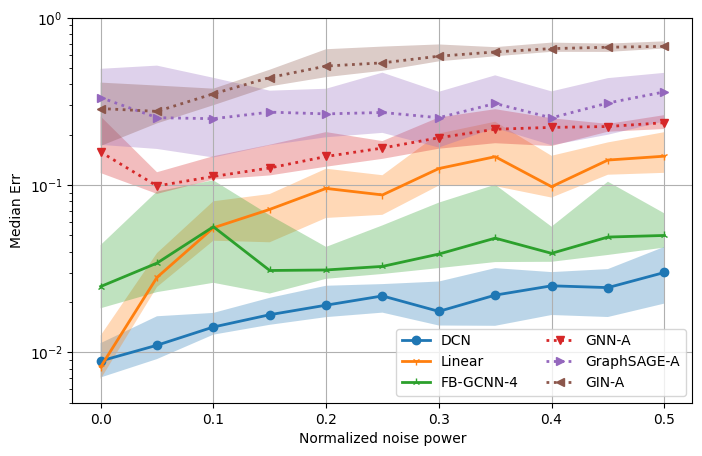

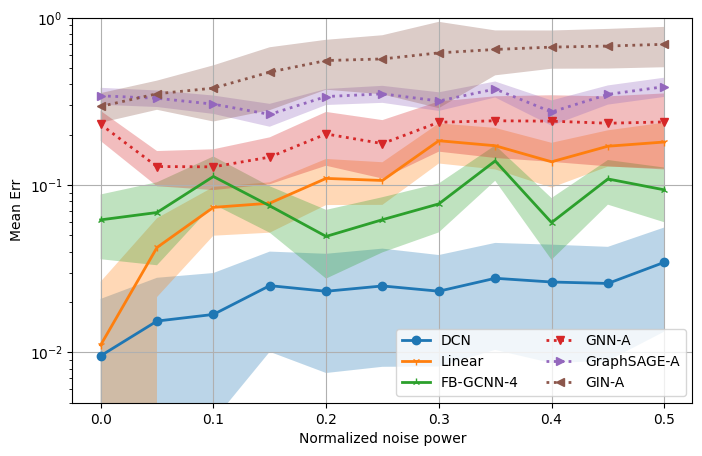

In [9]:
mean_err = err.mean(axis=0)
std_err = std.mean(axis=0)
med_err = np.median(err, axis=0)
prctile25_err = np.percentile(err, 25, axis=0)
prctile75_err = np.percentile(err, 75, axis=0)

if SAVE:
    file_name = PATH + f'noise/noise_inf-{data_p["src_t"]}'
    np.savez(file_name, err=err, std=std, times=times, exp=Exps, xvals=Noise_values)
    print('SAVED FILE:', file_name)

    # Save csv files for pgfplot
    file_name_data = f'{file_name}-mean_err.csv'
    utils.data_to_csv(file_name_data, Exps, Noise_values, mean_err)
    file_name_data = f'{file_name}-std_up_err.csv'
    utils.data_to_csv(file_name_data, Exps, Noise_values, mean_err + std_err)
    file_name_data = f'{file_name}-std_down_err.csv'
    utils.data_to_csv(file_name_data, Exps, Noise_values, mean_err - std_err)
    file_name_data = f'{file_name}-med_err.csv'
    utils.data_to_csv(file_name_data, Exps, Noise_values, med_err)
    file_name_data = f'{file_name}-prct75_err.csv'
    utils.data_to_csv(file_name_data, Exps, Noise_values, prctile75_err)
    file_name_data = f'{file_name}-prct25_err.csv'
    utils.data_to_csv(file_name_data, Exps, Noise_values, prctile25_err)

legend = [exp['leg'] for exp in Exps]

skip = [1, 2, 4, 5, 6, 7, 10] #[1,3,5,6, 7, 11, 12]
utils.plot_results(med_err, Noise_values, Exps, 'Normalized noise power', skip_idx=skip, n_cols=2, ylabel='Median Err',
                   ylim_top=1, logy=True, prctile_up=prctile75_err, prctile_low=prctile25_err, ylim_bottom=5e-3)

utils.plot_results(mean_err, Noise_values, Exps, 'Normalized noise power', skip_idx=skip, n_cols=2, ylabel='Mean Err',
                   ylim_top=1, logy=True, std=std_err, ylim_bottom=5e-3)




In [10]:
# file_name = PATH + 'noise/noise_inf-constant-noisy_test.npz'
# err, std, times, Exps, Noise_values = utils.load_data(file_name)

## Additional Eperiments

### Varying the size of the graph

In [ ]:
def influence_graph_size(d_dat_p, d_arc_p, d_mod_p, N_nodes, mean_edges_per_node, exps,
                         sel_GSOs='last', incr_GSOs=True, inc_srcs=True):
    err = np.zeros((d_dat_p['n_tries'], len(N_nodes), len(exps)))
    std = np.zeros((d_dat_p['n_tries'], len(N_nodes), len(exps)))
    times = np.zeros((d_dat_p['n_tries'], len(N_nodes), len(exps)))
    
    t_begin = time.time()
    for i in range(d_dat_p['n_tries']):
        print('Realization:', i)

        for j, n_nodes in enumerate(N_nodes):
            data_params_aux = dict(d_dat_p)
            data_params_aux['N'] = n_nodes
            edges = n_nodes*mean_edges_per_node
            data_params_aux['p'] = float(edges*2)/float(n_nodes**2 - n_nodes)

            if inc_srcs:
                data_params_aux['max_src_node'] = int(n_nodes/4)
                data_params_aux['n_sources'] = max(int(n_nodes/20), 1)

            if sel_GSOs == 'all':
                data_params_aux['max_GSO'] = n_nodes
                data_params_aux['min_GSO'] = 0
            else:
                # Always use second half of nodes to generate data
                data_params_aux['max_GSO'] = n_nodes
                data_params_aux['min_GSO'] = int(n_nodes/2)
            
            available_nodes = data_params_aux['max_GSO'] - data_params_aux['min_GSO']
            if incr_GSOs: # and available_nodes > d_dat_p['n_GSOs']:
                data_params_aux['n_GSOs'] = int(available_nodes/2)  # max(int(available_nodes/2), d_dat_p['n_GSOs'])
            else:
                data_params_aux['n_GSOs'] = min(d_dat_p['n_GSOs'], available_nodes)
            

            Adj, W, GSOs, Psi = utils.get_graph_data(data_params_aux, get_Psi=True)

            exp_desc = f'N: {Adj.shape[0]}, p: { data_params_aux["p"]:.3f}'

            err[i,j], std[i,j], times[i,j] = run_exps(exps, d_arc_p, d_mod_p, data_params_aux, GSOs, W,
                                                      Adj, exp_desc=exp_desc, Psi=Psi)

            err[i,j][err[i,j] > 1] = 1

    total_t = (time.time() - t_begin)/60
    print(f'----- Ellapsed time: {total_t:.2f} minutes -----')

    return err, std, times

In [ ]:
mean_edges_per_node = 5
N_nodes = np.array([25, 50, 100, 200, 400]) # np.logspace(np.log10(25), np.log10(400), 7, dtype=int) 

Exps = [
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs'}, 'mod_p': {}, 'leg': 'DCN', 'fmt': 'o-'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 20}, 'mod_p': {}, 'leg': 'DCN-20', 'fmt': 'o--'},

    {'arc_p': {'arch': LinDAGRegModel, 'GSO': 'GSOs'}, 'leg': 'Linear', 'fmt': 's-'},

    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'A_pows', 'K': 4, 'transp': False}, 'leg': 'FB-GCNN-3', 'fmt': '2:'},
    {'arc_p': {'arch': MyGCNN, 'GSO': 'A'}, 'leg': 'GNN-A', 'fmt': 'v:'},
    {'arc_p': {'arch': GAT, 'GSO': 'A-dgl', 'n_heads': 2, 'hid_dim': 16, 'gat_params': {'attn_drop': 0}},
     'leg': 'GAT-A', 'fmt': '^:'},
    {'arc_p': {'arch': GraphSAGE, 'GSO': 'A-dgl', 'hid_dim': 16, 'agg': 'mean'}, 'leg': 'GraphSAGE-A',
     'fmt': '>:'},
    {'arc_p': {'arch': GIN, 'GSO': 'A-dgl', 'hid_dim': 16, 'agg': 'sum'}, 'leg': 'GIN-A',
     'fmt': '<:'},
    ]

err, std, times = influence_graph_size(data_p, default_arch_p, default_mod_p, N_nodes,
                                       mean_edges_per_node, Exps)


Realization: 0
	-N: 25, p: 0.417. DCN: err: 0.004 - time: 3.6
	-N: 25, p: 0.417. DCN-20: err: 0.004 - time: 3.6
	-N: 25, p: 0.417. Linear: err: 0.027 - time: 0.0
	-N: 25, p: 0.417. FB-GCNN-3: err: 0.039 - time: 3.4
	-N: 25, p: 0.417. GNN-A: err: 0.086 - time: 3.2
	-N: 25, p: 0.417. GAT-A: err: 0.502 - time: 13.9
	-N: 25, p: 0.417. GraphSAGE-A: err: 0.301 - time: 5.9
	-N: 25, p: 0.417. GIN-A: err: 0.924 - time: 5.5
	-N: 50, p: 0.204. DCN: err: 0.025 - time: 3.7
	-N: 50, p: 0.204. DCN-20: err: 0.015 - time: 3.4
	-N: 50, p: 0.204. Linear: err: 0.033 - time: 0.1
	-N: 50, p: 0.204. FB-GCNN-3: err: 0.238 - time: 3.3
	-N: 50, p: 0.204. GNN-A: err: 0.137 - time: 3.1
	-N: 50, p: 0.204. GAT-A: err: 0.344 - time: 13.9
	-N: 50, p: 0.204. GraphSAGE-A: err: 0.462 - time: 5.3
	-N: 50, p: 0.204. GIN-A: err: 0.123 - time: 6.1
	-N: 100, p: 0.101. DCN: err: 0.019 - time: 4.1
	-N: 100, p: 0.101. DCN-20: err: 0.022 - time: 3.6
	-N: 100, p: 0.101. Linear: err: 0.043 - time: 0.3
	-N: 100, p: 0.101. FB-GCNN-3

/home/srey/Investigacion/dag_conv_nn/src/models.py:196: RuntimeWarning: divide by zero encountered in divide
  err = (np.linalg.norm(Y_hat - Y, axis=0)/norm_Y)**2
/home/srey/Investigacion/dag_conv_nn/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


	-N: 50, p: 0.204. DCN-20: err: inf - time: 3.5
	-N: 50, p: 0.204. Linear: err: 0.035 - time: 0.1
	-N: 50, p: 0.204. FB-GCNN-3: err: 0.289 - time: 3.3
	-N: 50, p: 0.204. GNN-A: err: 0.506 - time: 3.2
	-N: 50, p: 0.204. GAT-A: err: 0.393 - time: 14.0
	-N: 50, p: 0.204. GraphSAGE-A: err: 0.221 - time: 5.3
	-N: 50, p: 0.204. GIN-A: err: 0.667 - time: 5.6
	-N: 100, p: 0.101. DCN: err: 0.056 - time: 3.9
	-N: 100, p: 0.101. DCN-20: err: 0.071 - time: 3.6
	-N: 100, p: 0.101. Linear: err: 0.021 - time: 0.3
	-N: 100, p: 0.101. FB-GCNN-3: err: 0.060 - time: 3.5
	-N: 100, p: 0.101. GNN-A: err: 0.187 - time: 2.8
	-N: 100, p: 0.101. GAT-A: err: 0.572 - time: 13.8
	-N: 100, p: 0.101. GraphSAGE-A: err: 0.610 - time: 5.0
	-N: 100, p: 0.101. GIN-A: err: 0.307 - time: 5.8
	-N: 200, p: 0.050. DCN: err: 0.015 - time: 15.5
	-N: 200, p: 0.050. DCN-20: err: 0.037 - time: 3.2
	-N: 200, p: 0.050. Linear: err: 0.078 - time: 1.5
	-N: 200, p: 0.050. FB-GCNN-3: err: 0.135 - time: 3.3
	-N: 200, p: 0.050. GNN-A: err

SAVED FILE: results/diffusion/graph_size/n_nodes_inf-constant
SAVED as: results/diffusion/graph_size/n_nodes_inf-constant-mean_err.csv
SAVED as: results/diffusion/graph_size/n_nodes_inf-constant-std_up_err.csv
SAVED as: results/diffusion/graph_size/n_nodes_inf-constant-std_down_err.csv
SAVED as: results/diffusion/graph_size/n_nodes_inf-constant-med_err.csv
SAVED as: results/diffusion/graph_size/n_nodes_inf-constant-prct75_err.csv
SAVED as: results/diffusion/graph_size/n_nodes_inf-constant-prct25_err.csv


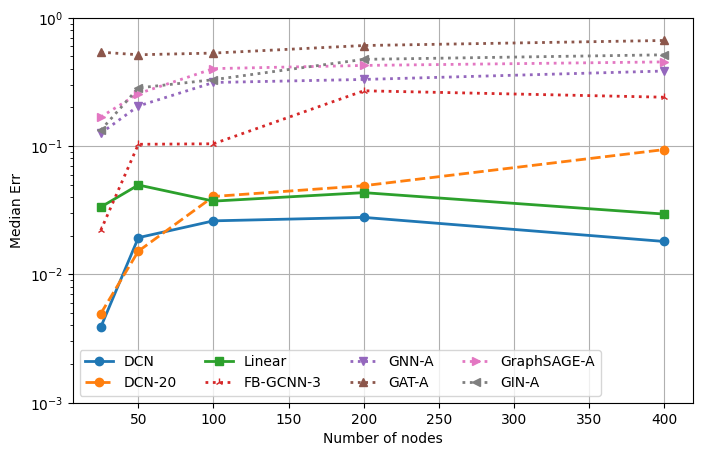

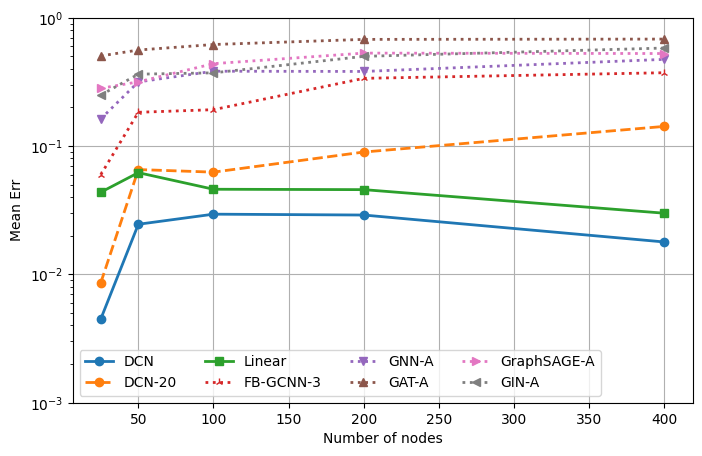

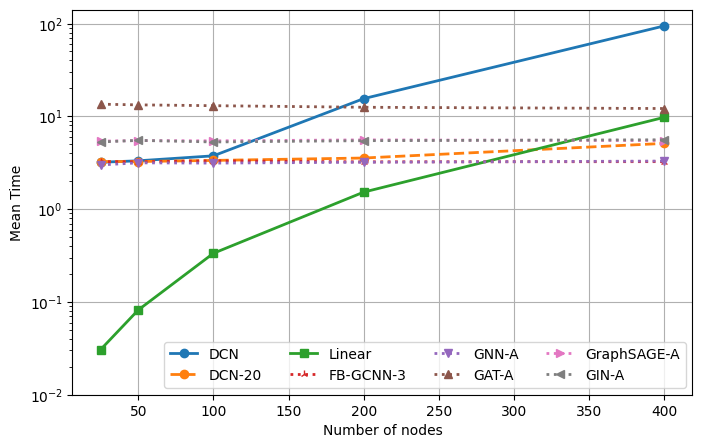

In [ ]:
mean_err = err.mean(axis=0)
std_err = err.std(axis=0)
med_err = np.median(err, axis=0)
std_err = err.std(axis=0)
prctile25_err = np.percentile(err, 25, axis=0)
prctile75_err = np.percentile(err, 75, axis=0)
mean_time = times.mean(axis=0)

if SAVE:
    file_name = PATH + f'graph_size/n_nodes_inf-{data_p["src_t"]}'
    np.savez(file_name, err=err, std=std, times=times, exp=Exps, xvals=N_nodes)
    print('SAVED FILE:', file_name)

    # Save csv files for pgfplot
    file_name_data = f'{file_name}-mean_err.csv'
    utils.data_to_csv(file_name_data, Exps, N_nodes, mean_err)
    file_name_data = f'{file_name}-std_up_err.csv'
    utils.data_to_csv(file_name_data, Exps, N_nodes, mean_err + std_err)
    file_name_data = f'{file_name}-std_down_err.csv'
    utils.data_to_csv(file_name_data, Exps, N_nodes, mean_err - std_err)
    file_name_data = f'{file_name}-med_err.csv'
    utils.data_to_csv(file_name_data, Exps, N_nodes, med_err)
    file_name_data = f'{file_name}-prct75_err.csv'
    utils.data_to_csv(file_name_data, Exps, N_nodes, prctile75_err)
    file_name_data = f'{file_name}-prct25_err.csv'
    utils.data_to_csv(file_name_data, Exps, N_nodes, prctile25_err)


### WITH PRCTILES
skip = []  # [1, 6, 9]
legend = [exp['leg'] for exp in Exps]
utils.plot_results(med_err, N_nodes, Exps, 'Number of nodes', skip_idx=skip, n_cols=4,
                   ylabel='Median Err', logy=True, ylim_top=1, ylim_bottom=1e-3)

utils.plot_results(mean_err, N_nodes, Exps, 'Number of nodes', skip_idx=skip, n_cols=4,
                   ylabel='Mean Err', logy=True, ylim_top=1, ylim_bottom=1e-3)

utils.plot_results(mean_time, N_nodes, Exps, 'Number of nodes', skip_idx=skip, n_cols=4,
                   ylabel='Mean Time', logy=True, ylim_top=None, ylim_bottom=1e-2)

In [ ]:
# file_name = PATH + 'graph_size/n_nodes_inf-constant.npz'
# err, std, times, Exps, N_nodes = utils.load_data(file_name)

### Influence of selected GSOs

In [11]:
def influence_gso_exp(d_dat_p, d_arc_p, d_mod_p, N_GSOs, exps):
    err = np.zeros((d_dat_p['n_tries'], len(N_GSOs), len(exps)))
    std = np.zeros((d_dat_p['n_tries'], len(N_GSOs), len(exps)))
    times = np.zeros((d_dat_p['n_tries'], len(N_GSOs), len(exps)))
    t_begin = time.time()

    for i in range(d_dat_p['n_tries']):
        print('Iteration:', i)
        Adj, W, GSOs, Psi = utils.get_graph_data(d_dat_p, get_Psi=True)

        for j, n_gsos in enumerate(N_GSOs):
            data_params_aux = dict(d_dat_p)
            data_params_aux['n_GSOs'] = n_gsos
            err[i,j], std[i,j], times[i,j] = run_exps(exps, d_arc_p, d_mod_p, data_params_aux, GSOs, W,
                                                      Adj, Psi=Psi, exp_desc=str(n_gsos))

    total_t = (time.time() - t_begin)/60
    print(f'----- Ellapsed time: {total_t:.2f} minutes -----')
    return err, std, times


In [12]:
Exps = [
    {'dat_p': {'min_GSO': 0, 'max_GSO': 100}, 'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs'}, 'mod_p': {},
     'leg': 'DCN, All', 'fmt': 'o-'},
    # {'arc_p': {'arch': LinDAGRegModel, 'GSO': 'GSOs'}, 'leg': 'Linear', 'fmt': '1-'},
    {'dat_p': {'min_GSO': 0, 'max_GSO': 100}, 'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 20},
     'mod_p': {}, 'leg': 'DCN-Rnd-20, All', 'fmt': 's-'},
    {'dat_p': {'min_GSO': 0, 'max_GSO': 100}, 'arc_p': {'arch': FB_DAGConv, 'GSO': 'A_pows', 'K': 3, 'transp': False},
     'leg': 'FB-GCNN-3', 'fmt': '2-'},


    
    
    {'dat_p': {'min_GSO': 0, 'max_GSO': 60}, 'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs'}, 'mod_p': {},
     'leg': 'DCN, Firsts', 'fmt': 'o--'},
    {'dat_p': {'min_GSO': 0, 'max_GSO': 60}, 'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 20},
     'mod_p': {}, 'leg': 'DCN-Rnd-20, Firsts', 'fmt': 's--'},
    {'dat_p': {'min_GSO': 0, 'max_GSO': 60}, 'arc_p': {'arch': FB_DAGConv, 'GSO': 'A_pows', 'K': 3, 'transp': False},
     'leg': 'FB-GCNN-3', 'fmt': '2--'},

    {'dat_p': {'min_GSO': 40, 'max_GSO': 100}, 'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs'}, 'mod_p': {},
     'leg': 'DCN, Lasts', 'fmt': 'o:'},
    {'dat_p': {'min_GSO': 40, 'max_GSO': 100}, 'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 20},
     'leg': 'DCN-Rnd-20, Lasts', 'fmt': 's:'},
    {'dat_p': {'min_GSO': 40, 'max_GSO': 100}, 'arc_p': {'arch': FB_DAGConv, 'GSO': 'A_pows', 'K': 3, 'transp': False},
     'leg': 'FB-GCNN-3', 'fmt': '2:'},
    ]

N_GSOs = [10, 20, 40, 55]  # np.arange(5, 41, 5)

err, std, times = influence_gso_exp(data_p, default_arch_p, default_mod_p, N_GSOs, Exps)

Iteration: 0
	-10. DCN, All: err: 0.012 - time: 3.8
	-10. DCN-Rnd-20, All: err: 0.244 - time: 3.8
	-10. FB-GCNN-3: err: 0.355 - time: 3.8
	-10. DCN, Firsts: err: 0.015 - time: 3.8
	-10. DCN-Rnd-20, Firsts: err: 0.144 - time: 3.0
	-10. FB-GCNN-3: err: 0.070 - time: 2.9
	-10. DCN, Lasts: err: 0.010 - time: 3.7
	-10. DCN-Rnd-20, Lasts: err: 0.013 - time: 2.9
	-10. FB-GCNN-3: err: 0.023 - time: 3.5
	-20. DCN, All: err: 0.023 - time: 2.8
	-20. DCN-Rnd-20, All: err: 0.170 - time: 3.6
	-20. FB-GCNN-3: err: 0.054 - time: 3.5
	-20. DCN, Firsts: err: 0.093 - time: 3.8
	-20. DCN-Rnd-20, Firsts: err: 0.070 - time: 3.7
	-20. FB-GCNN-3: err: 0.249 - time: 3.1
	-20. DCN, Lasts: err: 0.012 - time: 3.8
	-20. DCN-Rnd-20, Lasts: err: 0.015 - time: 3.7
	-20. FB-GCNN-3: err: 0.159 - time: 3.4
	-40. DCN, All: err: 0.021 - time: 3.7
	-40. DCN-Rnd-20, All: err: 0.024 - time: 2.9
	-40. FB-GCNN-3: err: 0.084 - time: 3.4
	-40. DCN, Firsts: err: 0.021 - time: 3.7
	-40. DCN-Rnd-20, Firsts: err: 0.083 - time: 3.3
	

SAVED FILE: results/diffusion/gso_inf-constant


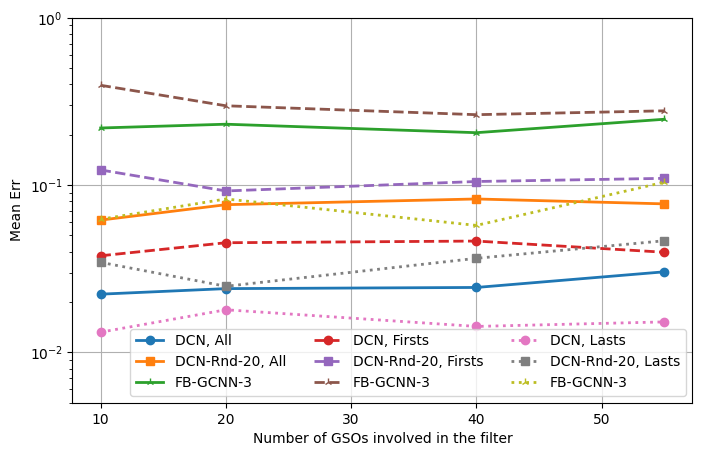

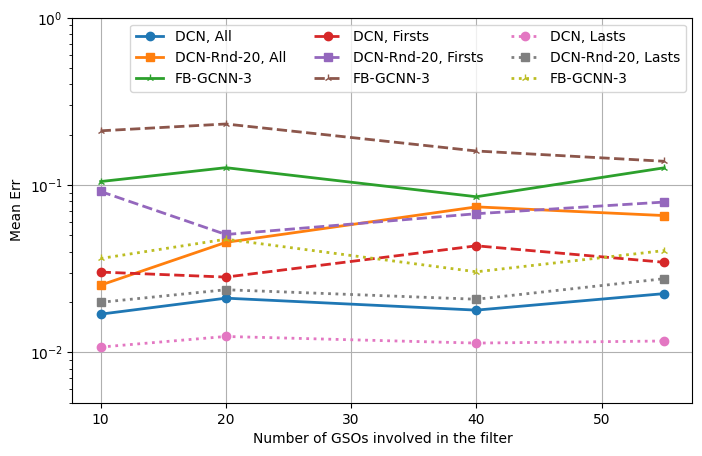

In [13]:
if SAVE:
    file_name = PATH + f'gso_inf-{data_p["src_t"]}'
    np.savez(file_name, err=err, std=std, times=times, exp=Exps, xvals=N_GSOs)
    print('SAVED FILE:', file_name)

mean_err = err.mean(axis=0)
med_err = np.median(err, axis=0)

skip_idx = [] # [2, 3, 6, 7, 10, 11]
utils.plot_results(mean_err, N_GSOs, Exps, 'Number of GSOs involved in the filter',
                   skip_idx=skip_idx, n_cols=3, ylim_bottom=5e-3)

utils.plot_results(med_err, N_GSOs, Exps, 'Number of GSOs involved in the filter',
                   skip_idx=skip_idx, n_cols=3, ylim_bottom=5e-3)

# skip_idx = [0, 1, 4, 5, 8, 9]
# utils.plot_results(med_err, N_GSOs, Exps, 'Number of GSOs involved in the filter',
#                    skip_idx=skip_idx, n_cols=3)

In [14]:
# file_name = PATH + 'gso_inf-constant.npz'
# err, std, times, Exps, N_GSOs = utils.load_data(file_name)

### Influence of the number of source nodes

In [15]:
def influence_sources_exp(d_dat_p, d_arc_p, d_mod_p, N_sources, exps):
    err = np.zeros((d_dat_p['n_tries'], len(N_sources), len(exps)))
    std = np.zeros((d_dat_p['n_tries'], len(N_sources), len(exps)))
    times = np.zeros((d_dat_p['n_tries'], len(N_sources), len(exps)))
    
    t_begin = time.time()
    for i in range(d_dat_p['n_tries']):
        print('Iteration:', i)

        Adj, W, GSOs, Psi = utils.get_graph_data(d_dat_p, get_Psi=True)

        for j, n_sources in enumerate(N_sources):
            data_params_aux = dict(d_dat_p)
            data_params_aux['n_sources'] = n_sources
            err[i,j], std[i,j], times[i,j] = run_exps(exps, d_arc_p, d_mod_p, data_params_aux, GSOs, W,
                                                      Adj, Psi=Psi, exp_desc=str(n_sources))

    total_t = (time.time() - t_begin)/60
    print(f'----- Ellapsed time: {total_t:.2f} minutes -----')
    return err, std, times

In [16]:
M = 2000
data_soruces = dict(data_p)
data_soruces['max_src_node'] = 50

N_sources = [1, 10, 20, 30, 40, 50]  #[1, 5, 10, 15, 20, 25]

Exps = [
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs'}, 'mod_p': {}, 'leg': 'DCN', 'fmt': 'o-'},
    # {'arc_p': {'arch': FB_DAGConv, 'GSO': 'sel_GSOs'}, 'mod_p': {}, 'leg': 'DCN-Prior', 'fmt': 'P--'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 20}, 'mod_p': {}, 'leg': 'DCN-20', 'fmt': 'o--'},

    {'arc_p': {'arch': LinDAGRegModel, 'GSO': 'GSOs'}, 'leg': 'Linear', 'fmt': 's-'},
    {'arc_p': {'arch': LinDAGRegModel, 'GSO': 'rnd_GSOs', 'n_gsos': 20}, 'leg': 'Linear-20', 'fmt': 's--'},

    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'A_pows', 'K': 4, 'transp': False}, 'leg': 'FB-GCNN-3', 'fmt': '1:'},
    {'arc_p': {'arch': MyGCNN, 'GSO': 'A'}, 'leg': 'GNN-A', 'fmt': 'v:'},
    {'arc_p': {'arch': GAT, 'GSO': 'A-dgl', 'n_heads': 2, 'hid_dim': 16, 'gat_params': {'attn_drop': 0}},
     'leg': 'GAT-A', 'fmt': '^:'},
    {'arc_p': {'arch': GraphSAGE, 'GSO': 'A-dgl', 'hid_dim': 16, 'agg': 'mean'}, 'leg': 'GraphSAGE-A',
     'fmt': '>:'},
    {'arc_p': {'arch': GIN, 'GSO': 'A-dgl', 'hid_dim': 16, 'agg': 'sum'}, 'leg': 'GIN-A',
     'fmt': '<:'},
    ]

err, std, times = influence_sources_exp(data_soruces, default_arch_p, default_mod_p, N_sources, Exps)


Iteration: 0
	-1. DCN: err: 0.020 - time: 3.8
	-1. DCN-20: err: 0.071 - time: 3.2
	-1. Linear: err: 0.066 - time: 0.4
	-1. Linear-20: err: 0.047 - time: 0.2
	-1. FB-GCNN-3: err: 0.136 - time: 3.3
	-1. GNN-A: err: 0.977 - time: 2.5
	-1. GAT-A: err: 0.558 - time: 13.1
	-1. GraphSAGE-A: err: 0.507 - time: 4.7
	-1. GIN-A: err: 0.135 - time: 5.4
	-10. DCN: err: 0.006 - time: 3.9
	-10. DCN-20: err: 0.014 - time: 3.4
	-10. Linear: err: 0.045 - time: 0.3
	-10. Linear-20: err: 0.072 - time: 0.2
	-10. FB-GCNN-3: err: 0.191 - time: 3.2
	-10. GNN-A: err: 0.192 - time: 3.3
	-10. GAT-A: err: 0.575 - time: 10.3
	-10. GraphSAGE-A: err: 0.465 - time: 5.0
	-10. GIN-A: err: 0.559 - time: 6.0
	-20. DCN: err: 0.026 - time: 3.7
	-20. DCN-20: err: 0.373 - time: 3.5
	-20. Linear: err: 0.037 - time: 0.4
	-20. Linear-20: err: 0.055 - time: 0.2
	-20. FB-GCNN-3: err: 0.035 - time: 3.2
	-20. GNN-A: err: 0.177 - time: 2.8
	-20. GAT-A: err: 0.591 - time: 12.9
	-20. GraphSAGE-A: err: 0.453 - time: 5.9
	-20. GIN-A: er

SAVED FILE: results/diffusion/sel_nodes/src_nodes_inf-constant


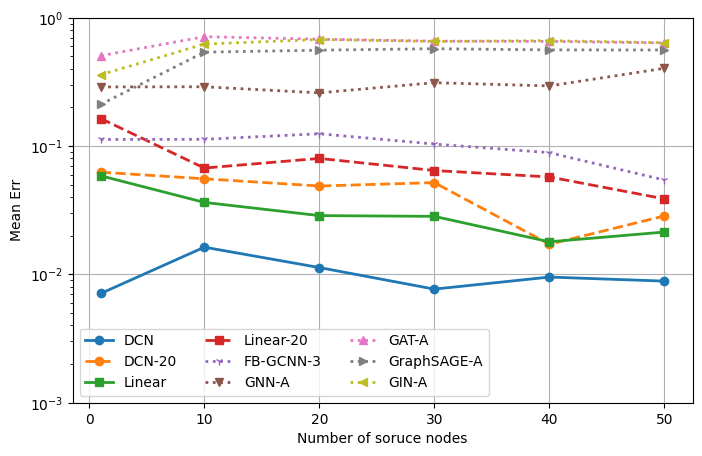

In [17]:
if SAVE:
    file_name = PATH + f'sel_nodes/src_nodes_inf-{data_p["src_t"]}'
    np.savez(file_name, err=err, std=std, times=times, exp=Exps, xvals=N_sources)
    print('SAVED FILE:', file_name)

mean_err = err.mean(axis=0)
med_err = np.median(err, axis=0)
legend = [exp['leg'] for exp in Exps]
utils.plot_results(mean_err, N_sources, Exps, 'Number of soruce nodes', ylim_bottom=1e-3)


In [18]:
# file_name = PATH + 'src_nodes_inf-constant.npz'
# err, std, times, Exps, N_sources = utils.load_data(file_name)

### Number of randomly selected GSOs

In [4]:
def influence_selected_gsp_exp(d_dat_p, d_arc_p, d_mod_p, N_GSOs, exps):
    err = np.zeros((d_dat_p['n_tries'], len(N_GSOs), len(exps)))
    std = np.zeros((d_dat_p['n_tries'], len(N_GSOs), len(exps)))
    times = np.zeros((d_dat_p['n_tries'], len(N_GSOs), len(exps)))
    
    t_begin = time.time()
    for i in range(d_dat_p['n_tries']):
        print('Realization:', i)

        Adj, W, GSOs, Psi = utils.get_graph_data(d_dat_p, get_Psi=True)

        for j, n_gsos in enumerate(N_GSOs):
            arch_params_aux = dict(d_arc_p)
            arch_params_aux['n_gsos'] = n_gsos

            err[i,j], std[i,j], times[i,j] = run_exps(exps, arch_params_aux, d_mod_p, d_dat_p, GSOs, W,
                                                      Adj, Psi=Psi, exp_desc=str(n_gsos))

    total_t = (time.time() - t_begin)/60
    print(f'----- Ellapsed time: {total_t:.2f} minutes -----')
    return err, std, times

#### Data generated with all GSOs

In [5]:
data_rnd_gsos = dict(data_p)
data_rnd_gsos['min_GSO'] = 0
data_rnd_gsos['max_GSO'] = 100
data_rnd_gsos['p'] = .1

M = 2000
N_GSOs = [5, 10, 15, 20, 25, 30, 45, 50, 55, 60]

Exps = [
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs'}, 'mod_p': {}, 'leg': 'DCN', 'fmt': 'o-'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs'}, 'mod_p': {}, 'leg': 'DCN-Rnd', 'fmt': 'v-'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'first_GSOs'}, 'mod_p': {}, 'leg': 'DCN-First', 'fmt': '^-'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'last_GSOs'}, 'mod_p': {}, 'leg': 'DCN-Last', 'fmt': '>-'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'no_sel_GSOs'}, 'mod_p': {}, 'leg': 'DCN-NoSel', 'fmt': '<-'},

    {'arc_p': {'arch': LinDAGRegModel, 'GSO': 'GSOs'}, 'leg': 'Linear', 'fmt': '1--'},
    {'arc_p': {'arch': LinDAGRegModel, 'GSO': 'rnd_GSOs'}, 'leg': 'Linear-Rnd', 'fmt': '2--'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'A_pows', 'K': 4, 'transp': False}, 'leg': 'FB-GCNN-4', 'fmt': '3:'},
    ]

err, std, times = influence_selected_gsp_exp(data_rnd_gsos, default_arch_p, default_mod_p, N_GSOs, Exps)


Realization: 0
	-5. DCN: err: 0.046 - time: 4.1
	-5. DCN-Rnd: err: 0.066 - time: 3.4
	-5. DCN-First: err: 0.682 - time: 3.4
	-5. DCN-Last: err: 0.404 - time: 3.5
	-5. DCN-NoSel: err: 0.207 - time: 3.0
	-5. Linear: err: 0.121 - time: 0.4
	-5. Linear-Rnd: err: 0.530 - time: 0.2
	-5. FB-GCNN-4: err: 0.111 - time: 3.6
	-10. DCN: err: 0.022 - time: 3.9
	-10. DCN-Rnd: err: 0.026 - time: 3.4
	-10. DCN-First: err: 0.597 - time: 3.5
	-10. DCN-Last: err: 0.042 - time: 3.3
	-10. DCN-NoSel: err: 0.108 - time: 3.0
	-10. Linear: err: 0.073 - time: 0.3
	-10. Linear-Rnd: err: 0.049 - time: 0.2
	-10. FB-GCNN-4: err: 0.161 - time: 3.5
	-15. DCN: err: 0.011 - time: 3.9
	-15. DCN-Rnd: err: 0.047 - time: 3.6
	-15. DCN-First: err: 0.348 - time: 3.2
	-15. DCN-Last: err: 0.599 - time: 3.5
	-15. DCN-NoSel: err: 0.041 - time: 3.5
	-15. Linear: err: 0.054 - time: 0.4
	-15. Linear-Rnd: err: 0.418 - time: 0.2
	-15. FB-GCNN-4: err: 0.069 - time: 3.3
	-20. DCN: err: 0.030 - time: 3.8
	-20. DCN-Rnd: err: 0.140 - time

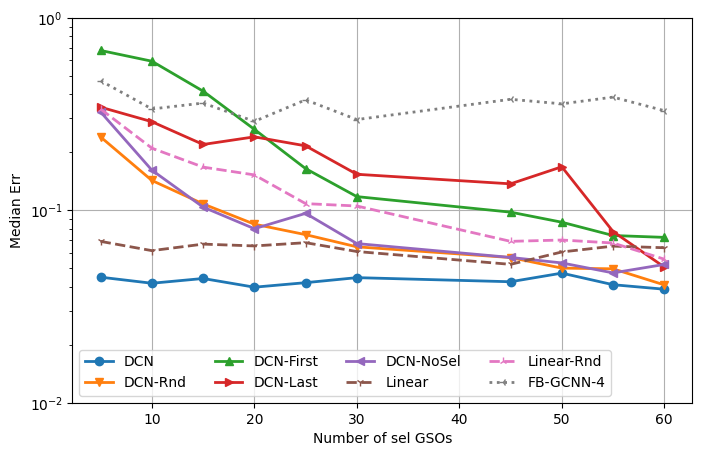

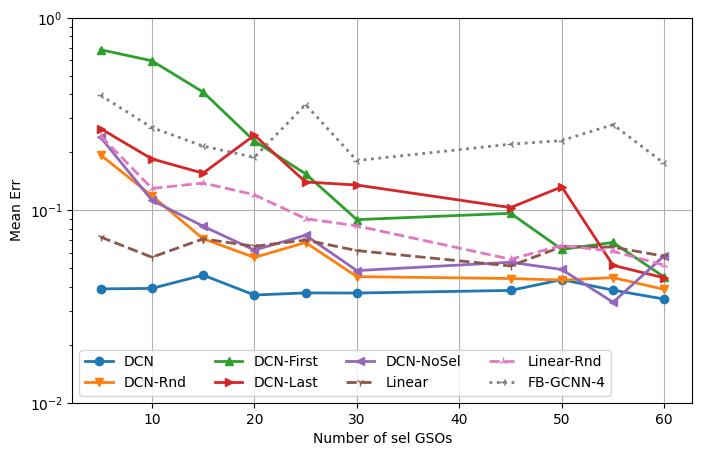

In [6]:
if SAVE:
    file_name = PATH + f'sel_gso_inf-from_all_gso-{data_p["src_t"]}'
    np.savez(file_name, err=err, std=std, times=times, exp=Exps, xvals=N_GSOs)
    print('SAVED FILE:', file_name)

mean_err = err.mean(axis=0)
mean_time = times.mean(axis=0)
med_err = np.median(err, axis=0)
med_time = np.median(times, axis=0)
legend = [exp['leg'] for exp in Exps]

# Selected
# skip = [0, 1, 2]
utils.plot_results(mean_err, N_GSOs, Exps, 'Number of sel GSOs', n_cols=4, ylabel='Median Err')

# All
utils.plot_results(med_err, N_GSOs, Exps, 'Number of sel GSOs', n_cols=4)

In [ ]:
# file_name = PATH + 'sel_gso_inf-from_all_gso-constant.npz'
# err, std, times, Exps, N_GSOs = utils.load_data(file_name)

#### Data generated with last GSOs

In [7]:
M = 2000
N_GSOs = [5, 10, 15, 20, 25, 30, 45, 50]

data_rnd_gsos = dict(data_p)
data_rnd_gsos['min_GSO'] = 49
data_rnd_gsos['max_GSO'] = 100
data_rnd_gsos['p'] = .1

Exps = [
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs'}, 'mod_p': {}, 'leg': 'DCN', 'fmt': 'o-'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs'}, 'mod_p': {}, 'leg': 'DCN-Rnd', 'fmt': 'v-'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'first_GSOs'}, 'mod_p': {}, 'leg': 'DCN-First', 'fmt': '^-'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'last_GSOs'}, 'mod_p': {}, 'leg': 'DCN-Last', 'fmt': '>-'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'no_sel_GSOs'}, 'mod_p': {}, 'leg': 'DCN-NoSel', 'fmt': '<-'},

    {'arc_p': {'arch': LinDAGRegModel, 'GSO': 'GSOs'}, 'leg': 'Linear', 'fmt': '1--'},
    {'arc_p': {'arch': LinDAGRegModel, 'GSO': 'rnd_GSOs'}, 'leg': 'Linear-Rnd', 'fmt': '2--'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'A_pows', 'K': 4, 'transp': False}, 'leg': 'FB-GCNN-4', 'fmt': '3:'},
    ]

err, std, times = influence_selected_gsp_exp(data_rnd_gsos, default_arch_p, default_mod_p, N_GSOs, Exps)


Realization: 0


	-5. DCN: err: 0.021 - time: 4.1
	-5. DCN-Rnd: err: 0.053 - time: 2.5
	-5. DCN-First: err: 0.719 - time: 2.9
	-5. DCN-Last: err: 0.068 - time: 3.7
	-5. DCN-NoSel: err: 0.458 - time: 3.3
	-5. Linear: err: 0.028 - time: 0.3
	-5. Linear-Rnd: err: 0.059 - time: 0.1
	-5. FB-GCNN-4: err: 0.096 - time: 3.9
	-10. DCN: err: 0.015 - time: 3.8
	-10. DCN-Rnd: err: 0.175 - time: 3.2
	-10. DCN-First: err: 0.398 - time: 3.5
	-10. DCN-Last: err: 0.091 - time: 2.8
	-10. DCN-NoSel: err: 0.067 - time: 3.6
	-10. Linear: err: 0.030 - time: 0.3
	-10. Linear-Rnd: err: 0.261 - time: 0.1
	-10. FB-GCNN-4: err: 0.370 - time: 3.3
	-15. DCN: err: 0.028 - time: 3.5
	-15. DCN-Rnd: err: 0.026 - time: 4.0
	-15. DCN-First: err: 0.359 - time: 3.7
	-15. DCN-Last: err: 0.319 - time: 2.9
	-15. DCN-NoSel: err: 0.026 - time: 2.9
	-15. Linear: err: 0.079 - time: 0.3
	-15. Linear-Rnd: err: 0.078 - time: 0.2
	-15. FB-GCNN-4: err: 0.040 - time: 3.9
	-20. DCN: err: 0.025 - time: 4.0
	-20. DCN-Rnd: err: 0.077 - time: 3.6
	-20. DCN

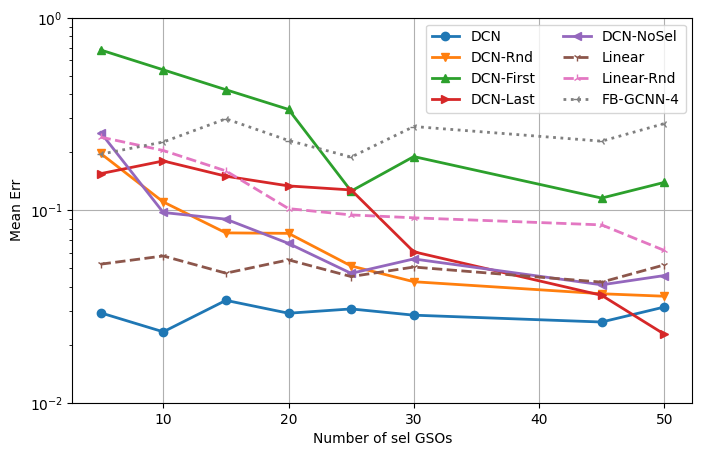

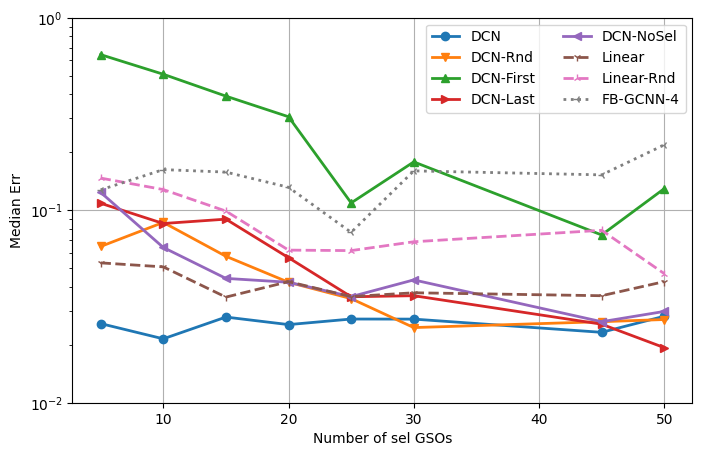

In [8]:
if SAVE:
    file_name = PATH + f'sel_gso_inf-{data_p["src_t"]}'
    np.savez(file_name, err=err, std=std, times=times, exp=Exps, xvals=N_GSOs)
    print('SAVED FILE:', file_name)

mean_err = err.mean(axis=0)
mean_time = times.mean(axis=0)
med_err = np.median(err, axis=0)
med_time = np.median(times, axis=0)
legend = [exp['leg'] for exp in Exps]
utils.plot_results(mean_err, N_GSOs, Exps, 'Number of sel GSOs', n_cols=2, ylabel='Mean Err')
utils.plot_results(med_err, N_GSOs, Exps, 'Number of sel GSOs', n_cols=2, ylabel='Median Err')

In [6]:
# file_name = PATH + 'sel_gso_inf-constant.npz'
# err, std, times, Exps, N_GSOs = utils.load_data(file_name)

### Influence of number of Layers

In [9]:
def influence_n_layers_exp(d_dat_p, d_arc_p, d_mod_p, N_layers, exps):
    err = np.zeros((d_dat_p['n_tries'], len(N_layers), len(exps)))
    std = np.zeros((d_dat_p['n_tries'], len(N_layers), len(exps)))
    times = np.zeros((d_dat_p['n_tries'], len(N_layers), len(exps)))
    
    t_begin = time.time()
    for i in range(d_dat_p['n_tries']):
        print('Realization:', i)

        Adj, W, GSOs, Psi = utils.get_graph_data(d_dat_p, get_Psi=True)

        for j, n_layers in enumerate(N_layers):
            arch_params_aux = dict(d_arc_p)
            arch_params_aux['L'] = n_layers

            err[i,j], std[i,j], times[i,j] = run_exps(exps, arch_params_aux, d_mod_p, d_dat_p, GSOs, W,
                                                      Adj, Psi=Psi, exp_desc=str(n_layers))

            err[i,j][err[i,j] > 1] = 1

    total_t = (time.time() - t_begin)/60
    print(f'----- Ellapsed time: {total_t:.2f} minutes -----')

    return err, std, times

In [10]:
N_layers = np.arange(1,9)


Exps = [
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs'}, 'mod_p': {}, 'leg': 'DCN', 'fmt': 'o-'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 20}, 'mod_p': {}, 'leg': 'DCN-20', 'fmt': 'o--'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 10}, 'mod_p': {}, 'leg': 'DCN-10', 'fmt': 'o-.'},

    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'A_pows', 'K': 2, 'transp': False}, 'leg': 'FB-GCNN-2', 'fmt': '1:'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'A_pows', 'K': 4, 'transp': False}, 'leg': 'FB-GCNN-4', 'fmt': '2:'},
    {'arc_p': {'arch': MyGCNN, 'GSO': 'A'}, 'leg': 'GNN-A', 'fmt': 'v:'},
    {'arc_p': {'arch': GraphSAGE, 'GSO': 'A-dgl', 'hid_dim': 16, 'agg': 'mean'}, 'leg': 'GraphSAGE-A',
     'fmt': '>:'},
    {'arc_p': {'arch': GIN, 'GSO': 'A-dgl', 'hid_dim': 16, 'agg': 'sum'}, 'leg': 'GIN-A',
     'fmt': '<:'},
    ]

err, std, times = influence_n_layers_exp(data_p, default_arch_p, default_mod_p, N_layers, Exps)


Realization: 0


	-1. DCN: err: 0.030 - time: 2.0
	-1. DCN-20: err: 0.051 - time: 1.9
	-1. DCN-10: err: 0.100 - time: 1.9
	-1. FB-GCNN-2: err: 0.453 - time: 1.9
	-1. FB-GCNN-4: err: 0.097 - time: 1.9
	-1. GNN-A: err: 0.754 - time: 1.9
	-1. GraphSAGE-A: err: 0.698 - time: 3.1
	-1. GIN-A: err: 0.883 - time: 2.8
	-2. DCN: err: 0.041 - time: 3.8
	-2. DCN-20: err: 0.018 - time: 3.9
	-2. DCN-10: err: 0.010 - time: 3.7
	-2. FB-GCNN-2: err: 0.282 - time: 3.4
	-2. FB-GCNN-4: err: 0.030 - time: 3.2
	-2. GNN-A: err: 0.087 - time: 3.8
	-2. GraphSAGE-A: err: 0.159 - time: 5.6
	-2. GIN-A: err: 0.258 - time: 5.3
	-3. DCN: err: 0.008 - time: 7.8
	-3. DCN-20: err: 0.069 - time: 4.9
	-3. DCN-10: err: 0.013 - time: 4.0
	-3. FB-GCNN-2: err: 0.020 - time: 5.0
	-3. FB-GCNN-4: err: 0.034 - time: 4.4
	-3. GNN-A: err: 0.086 - time: 5.0
	-3. GraphSAGE-A: err: 0.105 - time: 7.7
	-3. GIN-A: err: 0.790 - time: 7.3
	-4. DCN: err: 0.015 - time: 12.1
	-4. DCN-20: err: 0.011 - time: 5.2
	-4. DCN-10: err: 0.016 - time: 5.5
	-4. FB-GCNN

SAVED FILE: results/diffusion/layers/n_layers_inf-constant


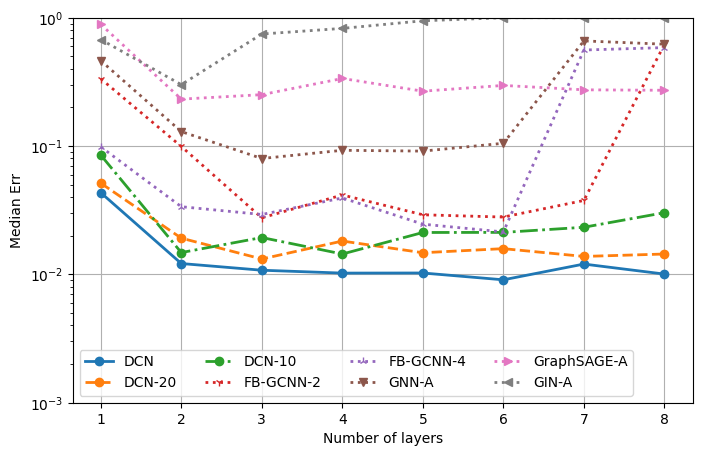

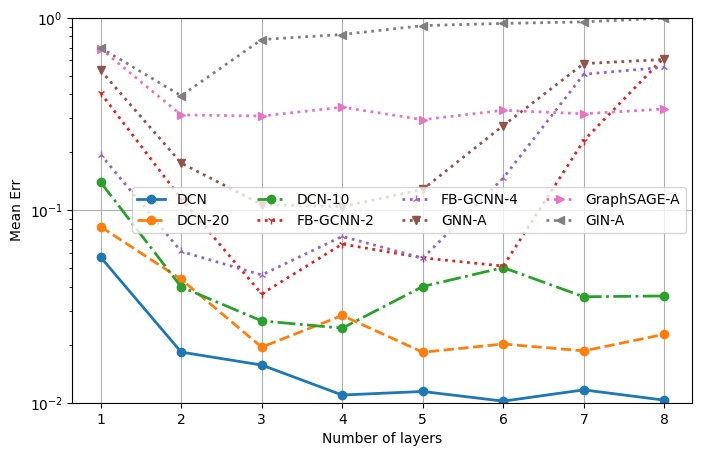

In [13]:
if SAVE:
    file_name = PATH + f'layers/n_layers_inf-{data_p["src_t"]}'
    np.savez(file_name, err=err, std=std, times=times, exp=Exps, xvals=N_layers)
    print('SAVED FILE:', file_name)

mean_err = err.mean(axis=0)
mean_time = times.mean(axis=0)
med_err = np.median(err, axis=0)
mean_std = np.mean(std, axis=0)
legend = [exp['leg'] for exp in Exps]
skip_idx = [8, 9, 10, 11]
# utils.plot_results(mean_err, N_layers, Exps, 'Number of layers', skip_idx=skip_idx, n_cols=2)
# utils.plot_results(mean_time, N_layers, Exps, 'Number of layer', ylabel='Mean time (seg)',
#                    skip_idx=skip_idx, n_cols=2, ylim_bottom=1, ylim_top=50)

# skip_idx = [0, 1, 2, 8]
# skip_idx = [0, 1, 2, 3, 5, 8]
skip_idx = []
utils.plot_results(med_err, N_layers, Exps, 'Number of layers', skip_idx=skip_idx, n_cols=4, ylabel='Median Err',
                   ylim_bottom=1e-3)
utils.plot_results(mean_err, N_layers, Exps, 'Number of layers', skip_idx=skip_idx, n_cols=4)



In [18]:
# file_name = PATH + 'layers/n_layers_inf-constant.npz'

### Varying the density of the graph

In [30]:
def influence_graph_density(d_dat_p, d_arc_p, d_mod_p, P_values, exps):
    err = np.zeros((d_dat_p['n_tries'], len(P_values), len(exps)))
    std = np.zeros((d_dat_p['n_tries'], len(P_values), len(exps)))
    times = np.zeros((d_dat_p['n_tries'], len(P_values), len(exps)))
    
    t_begin = time.time()
    for i in range(d_dat_p['n_tries']):
        print('Realization:', i)

        for j, p in enumerate(P_values):
            data_params_aux = dict(d_dat_p)
            data_params_aux['p'] = p            
            Adj, W, GSOs, Psi = utils.get_graph_data(data_params_aux, get_Psi=True)

            err[i,j], std[i,j], times[i,j] = run_exps(exps, d_arc_p, d_mod_p, data_params_aux, GSOs, W,
                                                      Adj, exp_desc=str(p), Psi=Psi)

            err[i,j][err[i,j] > 1] = 1

    total_t = (time.time() - t_begin)/60
    print(f'----- Ellapsed time: {total_t:.2f} minutes -----')

    return err, std, times

In [31]:
P_values = [.1, .2, .3, .4, .5, .6, .7, .8]

Exps = [
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs'}, 'mod_p': {}, 'leg': 'DCN', 'fmt': 'o-'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 20}, 'mod_p': {}, 'leg': 'DCN-20', 'fmt': 'o--'},

    {'arc_p': {'arch': LinDAGRegModel, 'GSO': 'GSOs'}, 'leg': 'Linear', 'fmt': 's-'},

    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'A_pows', 'K': 4, 'transp': False}, 'leg': 'FB-GCNN-3', 'fmt': '2:'},
    {'arc_p': {'arch': MyGCNN, 'GSO': 'A'}, 'leg': 'GNN-A', 'fmt': 'v:'},
    {'arc_p': {'arch': GAT, 'GSO': 'A-dgl', 'n_heads': 2, 'hid_dim': 16, 'gat_params': {'attn_drop': 0}},
     'leg': 'GAT-A', 'fmt': '^:'},
    {'arc_p': {'arch': GraphSAGE, 'GSO': 'A-dgl', 'hid_dim': 16, 'agg': 'mean'}, 'leg': 'GraphSAGE-A',
     'fmt': '>:'},
    {'arc_p': {'arch': GIN, 'GSO': 'A-dgl', 'hid_dim': 16, 'agg': 'sum'}, 'leg': 'GIN-A',
     'fmt': '<:'},
    ]

err, std, times = influence_graph_density(data_p, default_arch_p, default_mod_p, P_values, Exps)


Realization: 0
	-0.1. DCN: err: 0.043 - time: 4.0
	-0.1. DCN-20: err: 0.013 - time: 3.2
	-0.1. Linear: err: 0.058 - time: 0.3
	-0.1. FB-GCNN-3: err: 0.036 - time: 3.1
	-0.1. GNN-A: err: 0.284 - time: 3.1
	-0.1. GAT-A: err: 0.533 - time: 13.2
	-0.1. GraphSAGE-A: err: 0.293 - time: 4.7
	-0.1. GIN-A: err: 0.211 - time: 4.8
	-0.2. DCN: err: 0.029 - time: 3.9
	-0.2. DCN-20: err: 0.019 - time: 3.7
	-0.2. Linear: err: 0.021 - time: 0.3
	-0.2. FB-GCNN-3: err: 0.035 - time: 2.9
	-0.2. GNN-A: err: 0.163 - time: 3.2
	-0.2. GAT-A: err: 0.822 - time: 9.7
	-0.2. GraphSAGE-A: err: 0.312 - time: 5.9
	-0.2. GIN-A: err: 0.148 - time: 4.7
	-0.3. DCN: err: 0.028 - time: 3.3
	-0.3. DCN-20: err: 0.014 - time: 3.1
	-0.3. Linear: err: 0.036 - time: 0.4
	-0.3. FB-GCNN-3: err: 0.016 - time: 3.2
	-0.3. GNN-A: err: 0.090 - time: 3.0
	-0.3. GAT-A: err: 0.738 - time: 13.8
	-0.3. GraphSAGE-A: err: 0.250 - time: 5.5
	-0.3. GIN-A: err: 0.485 - time: 5.4
	-0.4. DCN: err: 0.009 - time: 3.7
	-0.4. DCN-20: err: 0.009 - ti

SAVED FILE: results/diffusion/density_inf-constant


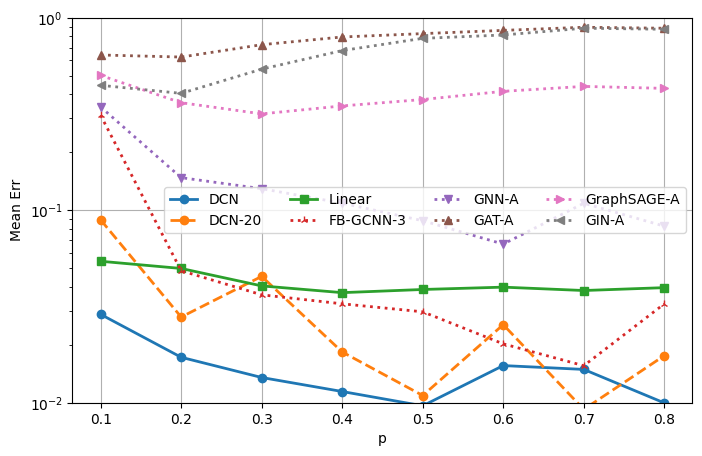

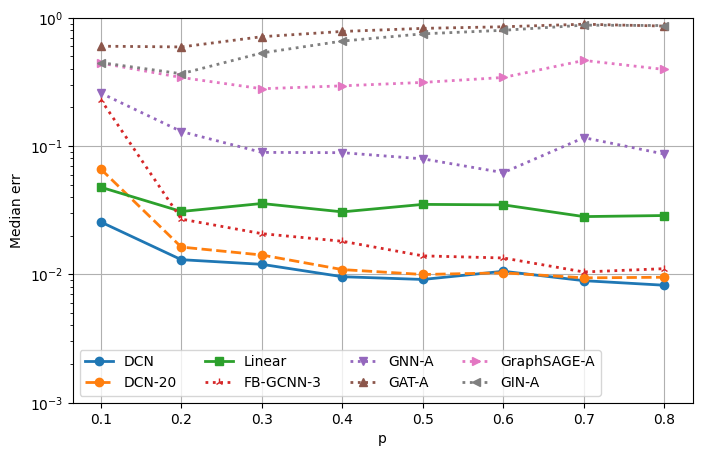

In [27]:
if SAVE:
    file_name = PATH + f'density_inf-{data_p["src_t"]}'
    np.savez(file_name, err=err, std=std, times=times, exp=Exps, xvals=P_values)
    print('SAVED FILE:', file_name)

mean_err = err.mean(axis=0)
mean_time = times.mean(axis=0)
med_err = np.median(err, axis=0)
legend = [exp['leg'] for exp in Exps]
utils.plot_results(mean_err, P_values, Exps, 'p', skip_idx=[], n_cols=4)

utils.plot_results(med_err, P_values, Exps, 'p', skip_idx=[], n_cols=4,
                   ylabel='Median err', ylim_bottom=1e-3)

In [24]:
# file_name = PATH + 'density_inf-constant.npz'
# err, std, times, Exps, P_values = utils.load_data(file_name)